# Study Case A
This notebook will showcase an overview of the Devices and Samples models, displaying statistical summaries and distribuitions for each model. Afterwards, we will add new features in attempt to answer the proposed questions.

## Questions and problem definition
**[WIP]** Define the problem and its questions

In [1]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import pyarrow.parquet as pq

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# configure visualizations
sns.set_style('whitegrid')
figsize=(8,6)


# helper functions
def load_df(path, columns=None, nthreads=4, strings_to_categorical=True):
    try:
        table = pq.read_table(path, columns=columns, nthreads=nthreads)
        return table.to_pandas(strings_to_categorical=strings_to_categorical)
    except Exception as e:
        print(e)

def downcast_ints(df):
    # downcast int types
    df_int = df.select_dtypes(include=['int'])
    converted_int = df_int.apply(pd.to_numeric, downcast='unsigned')
    df[converted_int.columns] = converted_int
    return df
        
def prepare_devices(path):
    cols = ['id', 'model', 'brand', 'manufacturer', 'product', 'os_version', 'kernel_version', 'is_root']
    return load_df(path, cols)
        
def prepare_samples(path):
    cols = ['device_id', 'timestamp', 'battery_level', 'network_status', 'screen_on', 
            'bluetooth_enabled', 'location_enabled', 'power_saver_enabled', 'nfc_enabled',
            'unknown_sources', 'developer_mode']
    
    # sorted by [device_id, timestamp]
    df = load_df(path, cols)

    df = df.reset_index(drop=True)

    df = downcast_ints(df)
    
    return df

## Acquire data
After importing the necessary libraries, we load the files into dataframes. The *samples* data was sorted beforehand by *device_id* and *timestamp*.

In [2]:
devices = prepare_devices('../src/devices.parquet')
samples = prepare_samples('../src/samples.parquet')

## Analyze by describing data
To better understand the data, we will start by looking at a sample of the data.

In [3]:
devices.sample(5)

,id,model,brand,manufacturer,product,os_version,kernel_version,is_root
563,564,sm-j510fn,samsung,samsung,j5xnltexx,6.0.1,3.10.49-11903637,0
2634,2635,sm-g925i,samsung,samsung,zeroltedv,7.0,3.10.61-11965133,0
878,879,sm-g930f,samsung,samsung,heroltexx,7.0,3.18.14-11104523,0
652,653,sm-t530,samsung,samsung,matissewifixx,5.0.2,3.4.0-10239154,0
3007,3008,e-boda sunny v37,e-boda,e-boda,e-boda_sunny_v37,4.4.2,3.4.67,1


In [4]:
samples.sample(5)

,device_id,timestamp,battery_level,network_status,screen_on,bluetooth_enabled,location_enabled,power_saver_enabled,nfc_enabled,unknown_sources,developer_mode
1090624,700,2017-10-23 00:17:26,28,disconnected,0,0,0,0,0,0,0
3829101,2596,2017-11-22 11:28:57,88,disconnected,0,0,1,0,0,1,0
1796566,1229,2017-11-08 09:03:46,51,wifi,1,0,0,0,0,0,0
3373832,2310,2017-11-27 05:08:42,52,wifi,0,0,1,1,0,0,0
625478,354,2017-10-28 11:33:06,62,wifi,1,0,0,0,0,1,0


### What are the data types for the various features?
#### Devices
- Six features are categories which represent device's specs.
- *is_root* is a boolean variable that indicates whether the device has root access.

#### Samples
- The last seven features are booleans, these are each device's settings.
- The remaining features will be useful to group the data into different subsets.

In [5]:
devices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3265 entries, 0 to 3264
Data columns (total 8 columns):
id                3265 non-null uint16
model             3265 non-null category
brand             3265 non-null category
manufacturer      3265 non-null category
product           3265 non-null category
os_version        3265 non-null category
kernel_version    3265 non-null category
is_root           3265 non-null uint8
dtypes: category(6), uint16(1), uint8(1)
memory usage: 193.3 KB


In [6]:
samples.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4587326 entries, 0 to 4587325
Data columns (total 11 columns):
device_id              uint16
timestamp              datetime64[ns]
battery_level          uint8
network_status         category
screen_on              uint8
bluetooth_enabled      uint8
location_enabled       uint8
power_saver_enabled    uint8
nfc_enabled            uint8
unknown_sources        uint8
developer_mode         uint8
dtypes: category(1), datetime64[ns](1), uint16(1), uint8(8)
memory usage: 83.1 MB


### What is the distribution of categorical features?

In [7]:
devices.describe(include=['category'])

,model,brand,manufacturer,product,os_version,kernel_version
count,3265,3265,3265,3265,3265,3265
unique,798,124,131,812,21,816
top,ale-l21,samsung,samsung,ale-l21,7.0,3.18.14-11104523
freq,165,1011,1006,165,1007,103


In [8]:
samples.describe(include=['category'])

,network_status
count,4587326
unique,20
top,wifi
freq,2458197


#### Inspecting *network_status* in greater detail
- We can verify that one of the most top values has label `0` which does not provide a meaningful value!

In [9]:
samples.network_status.value_counts()

wifi             2458197
disconnected     1360836
lte               433236
hspap             133264
utms               79950
0                  41508
hspa               36341
edge               22118
disconnecting      12470
hsupa               4228
hsdpa               3377
gprs                1421
connecting            99
19                    78
20                    71
evdo_a                47
30                    37
1xrtt                 30
16                    17
18                     1
Name: network_status, dtype: int64

### How many devices have samples?
Lets check what is the percentage of devices that uploaded **at least one sample**.

Defining the conversion goal, as the number of resgistered devices that upload samples, we can observe that:

The conversion is slightly below 50%, the conversion rate is not very high!

In [10]:
percentage = round(100 * samples.device_id.nunique() / devices.shape[0], 1)
print('From a population of {0} devices, {1} ' \
      'devices have samples, which represents {2}%'.format(devices.shape[0], samples.device_id.nunique(), percentage))

From a population of 3265 devices, 1597 devices have samples, which represents 48.9%


#### Additionally, we can calculate a few more conversion rates:

In [11]:
def calculate_conversion(limit):
    df = pd.DataFrame(samples.groupby('device_id').size() > limit, columns=['goal'])
    num = df[df.goal].shape[0]
    percentage = round(100 * num / devices.shape[0], 1)
    print('{0} devices have more than {1} samples, that represents {2}%'.format(num, limit, percentage))

calculate_conversion(100)
calculate_conversion(1000)

1137 devices have more than 100 samples, that represents 34.8%
693 devices have more than 1000 samples, that represents 21.2%


## Visualizing data
Visualizing data is crucial for recognizing underlying patterns to exploit in the model.

### How are the devices distributed according to brand and OS version?
We will plot the main features of the device's model, then we take a look at the sampling distribution.

[Text(0,0.5,'# Devices')]

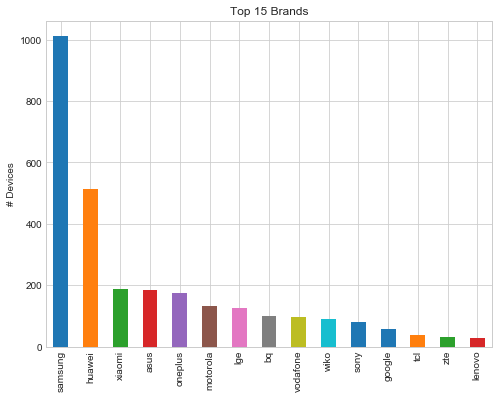

In [12]:
brands = devices.brand.value_counts()
pl = brands[0:15].plot(kind='bar', title='Top 15 Brands', figsize=figsize)
pl.set(ylabel='# Devices')

[Text(0,0.5,'# Devices')]

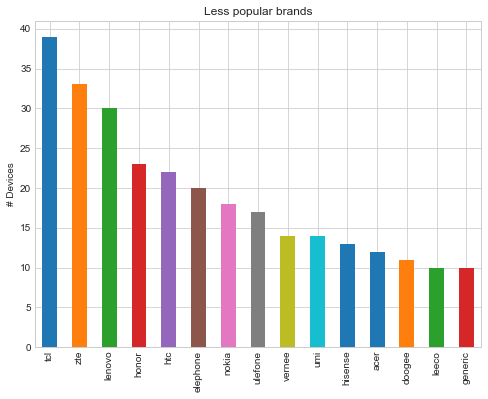

In [13]:
pl = brands[brands.between(10, 50)].plot(kind='bar', title='Less popular brands', figsize=figsize)
pl.set(ylabel='# Devices')

[Text(0,0.5,'# Devices')]

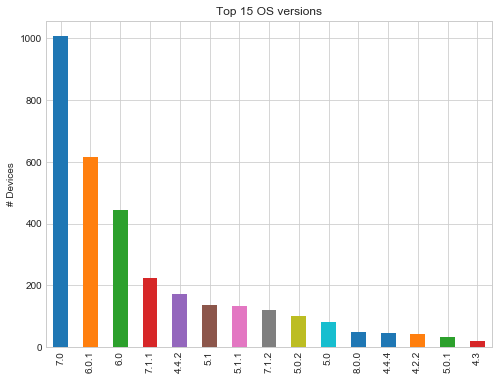

In [14]:
versions = devices.os_version.value_counts()
pl = versions[:15].plot(kind='bar', title='Top 15 OS versions', figsize=figsize)
pl.set(ylabel='# Devices')

[Text(0,0.5,'# Devices')]

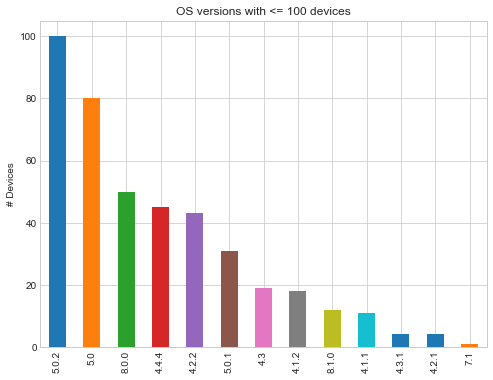

In [15]:
pl = versions[versions <= 100].plot(kind='bar', title='OS versions with <= 100 devices', figsize=figsize)
pl.set(ylabel='# Devices')

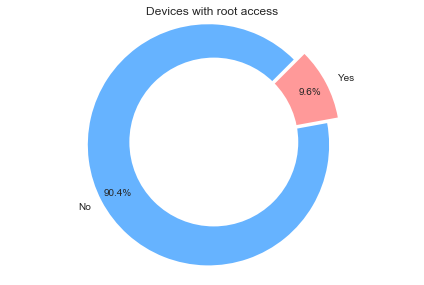

In [16]:
def plot_pie(data, labels, title, explode=(0.05, 0.05)):
    fig1, ax1 = plt.subplots()

    colors = ['#66b3ff', '#ff9999']

    ax1.pie(data, colors=colors, labels=labels,
            autopct='%1.1f%%', startangle=45, pctdistance=0.85, explode=explode)

    #draw circle
    centre_circle = plt.Circle((0,0),0.70,fc='white')
    fig = plt.gcf()
    fig.gca().add_artist(centre_circle)
    fig.suptitle(title)

    ax1.axis('equal')  
    plt.tight_layout()
    
plot_pie(devices.is_root.value_counts(), ['No', 'Yes'], 'Devices with root access')

[Text(0,0.5,'# Samples')]

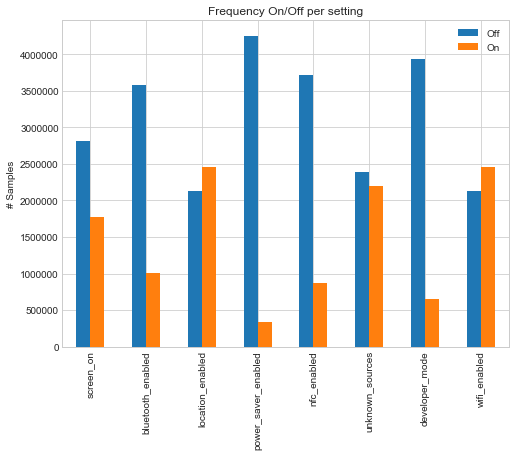

In [17]:
settings = ['screen_on', 'bluetooth_enabled', 'location_enabled', 'power_saver_enabled', 
            'nfc_enabled', 'unknown_sources', 'developer_mode', 'wifi_enabled']

# Add new setting
samples['wifi_enabled'] = (samples['network_status'] == 'wifi').astype(np.uint8)

# Frequency on/off per setting
freqs = samples[settings].apply(pd.value_counts, axis=0).T
freqs.columns = ['Off', 'On']
pl = freqs.plot(kind='bar', title='Frequency On/Off per setting', figsize=figsize)
pl.set(ylabel='# Samples')

## Transforming Features
1. First, add a new feature *wifi_enabled* (done in the previous step), will tell us if a sample has `wifi` value or some other status. This will be necessary to calculate another feature.
2. Next, calculate the changes over time and battery level, *time_diff* will be the time passed between each sample and *pct_change* the change percentage compared with the previous sample. The latter can be specially useful to group samples in batches of battery levels.
3. We will also add an extra feature *discharging* (`1.0` for discharge state, `0.0` for charge state) which will make it easier to group samples by battery state.
4. Combine the settings values into a numeric class, obtained by converting the group of values into a decimal number.
5. Lastly, drop useless features. We can drop the settings features since we have the *combination* value.

In [18]:
samples['time_diff'] = samples.timestamp.diff()
samples.loc[samples.device_id != samples.device_id.shift(), 'time_diff'] = None

samples['change'] = samples.battery_level.pct_change().round(2)
samples.loc[samples.device_id != samples.device_id.shift(), 'change'] = None

samples['discharging'] = samples.battery_level.shift() >= samples.battery_level
samples.loc[samples.device_id != samples.device_id.shift(), 'discharging'] = None

samples['combination'] = np.packbits(samples[settings].values, axis=-1)

samples = samples.drop(settings, axis=1)

samples.sample(5)

,device_id,timestamp,battery_level,network_status,time_diff,change,discharging,combination
4091830,2720,2018-01-23 18:46:59,32,hspa,00:00:30,-0.03,1.0,40
2935252,2046,2017-10-27 23:36:40,16,wifi,00:01:31,0.07,0.0,39
1882356,1290,2018-01-20 14:56:14,61,wifi,00:01:10,0.02,0.0,97
780005,430,2017-10-28 05:41:49,36,wifi,01:27:56,-0.14,1.0,237
3471182,2344,2017-10-20 03:51:19,60,disconnected,05:49:15,-0.02,1.0,8


[Text(0,0.5,'# Samples'), Text(0.5,0,'Combinations')]

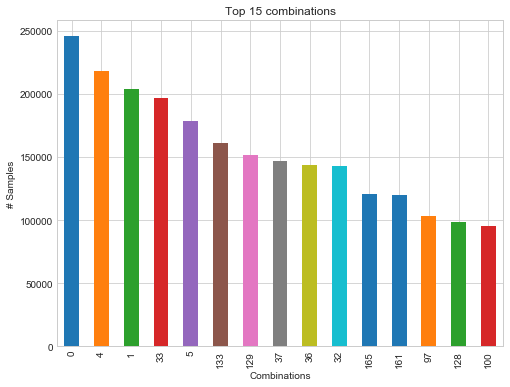

In [19]:
combs = samples.combination.value_counts().T
pl = combs[0:15].plot(kind='bar', title='Top 15 combinations', figsize=figsize)
pl.set(xlabel='Combinations', ylabel='# Samples')

### How many samples of each type overall and by device?
Next, we will group the samples by Device and count the samples of each state charging and discharging.
We can also calculate how many devices have each type of sample or even both. We use the *discharging* feature to group them.

The number of samples will differ **according to the sample type filter criteria!**

2319693 are charging samples, while 2266036 are discharging samples


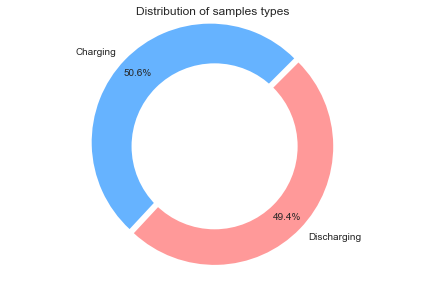

In [20]:
types = samples.discharging.value_counts()

plot_pie(types, ['Charging', 'Discharging'], 'Distribution of samples types', (0.05,0))

print('{0} are charging samples, while {1} are discharging samples' \
      .format(types[0], types[1]))

In [21]:
stypes = samples.groupby('device_id').discharging.value_counts().unstack().fillna(0)
stypes.columns = ['charging', 'discharging']
stypes = stypes.astype(np.int)
stypes = downcast_ints(stypes)

stypes.sample(5)

,charging,discharging
device_id,,
1020,754,1309
544,2074,1679
3175,460,1032
2473,1046,239
1459,2998,3596


In [22]:
both = stypes[(stypes.charging > 0) & (stypes.discharging > 0)].shape[0]
c_only = stypes[(stypes.charging > 0) & (stypes.discharging == 0)].shape[0]
d_only = stypes[(stypes.charging == 0) & (stypes.discharging > 0)].shape[0]

print('{0} devices have both types of samples, {1} only charging ' \
      'samples and {2} just discharging samples.'.format(both, c_only, d_only))

print('From all {0} unique devices, {1} are counted ' \
      'according to the filter criteria.' \
      .format(samples.device_id.unique().shape[0], stypes.index.unique().shape[0]))

1373 devices have both types of samples, 14 only charging samples and 88 just discharging samples.
From all 1597 unique devices, 1475 are counted according to the filter criteria.


### What is the distribution of samples with consecutive battery levels?
- Lets try to split the samples in batches of consecutive battery level values, to better understand, what is an average session of usage for a device.
- We will start by selecting only the samples with a **1%** change maximum.

In [23]:
change_interval = samples.change.between(-0.01, 0.01)

seqs = samples[change_interval].copy()

seqs['consecutive'] = abs(seqs.battery_level.shift() - seqs.battery_level) <= 1
seqs.loc[seqs.device_id != seqs.device_id.shift(), 'consecutive'] = False
seqs.loc[seqs.discharging != seqs.discharging.shift(), 'consecutive'] = False

def batch_len(s):
    return s * (s.groupby((s != s.shift()).cumsum()).cumcount() + 1)

seqs['batch'] = batch_len(seqs.consecutive)

seqs.shape[0]

1994054